# Project Description
This project will explore the Video [Game Sales dataset](https://www.kaggle.com/datasets/rush4ratio/video-game-sales-with-ratings). It features game sales split by region along with additional metrics for genre, ESRB rating, critic score, etc. The goal is to see how game sales relate to the other variables present in the dataset

# Load Packages

In [223]:
from mizani.formatters import * # this has various scales
import numpy as np
import pandas as pd
from plotnine import *
import plotnine
import plydata.cat_tools as cat
import warnings

plotnine.options.figure_size = (20, 10)
warnings.filterwarnings("ignore")
np.set_printoptions(threshold=np.inf)

# Load Data

In [224]:
df = pd.read_csv("Video_Games_Sales_as_at_22_Dec_2016.csv")

df.columns = df.columns.str.replace(" ", "_").str.lower()

df = df.assign(year_of_release = lambda x: x.year_of_release.astype("Int64"), 
               critic_count = lambda x: x.critic_count.astype("Int64"),
               user_count = lambda x: x.user_count.astype("Int64"))

df.head()

,name,platform,year_of_release,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales,critic_score,critic_count,user_score,user_count,developer,rating
0,Wii Sports,Wii,2006,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51,8,322,Nintendo,E
1,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,<NA>,NaN,<NA>,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73,8.3,709,Nintendo,E
3,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73,8,192,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,<NA>,NaN,<NA>,NaN,NaN


In [225]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16717 non-null  object 
 1   platform         16719 non-null  object 
 2   year_of_release  16450 non-null  Int64  
 3   genre            16717 non-null  object 
 4   publisher        16665 non-null  object 
 5   na_sales         16719 non-null  float64
 6   eu_sales         16719 non-null  float64
 7   jp_sales         16719 non-null  float64
 8   other_sales      16719 non-null  float64
 9   global_sales     16719 non-null  float64
 10  critic_score     8137 non-null   float64
 11  critic_count     8137 non-null   Int64  
 12  user_score       10015 non-null  object 
 13  user_count       7590 non-null   Int64  
 14  developer        10096 non-null  object 
 15  rating           9950 non-null   object 
dtypes: Int64(3), float64(6), object(7)
memory usage: 2.1+ MB


# Exploratory Data Analysis

## Top Selling Games of All Time
Before I get to breaking down the data by various categories, I want to observe the top selling games of all-time

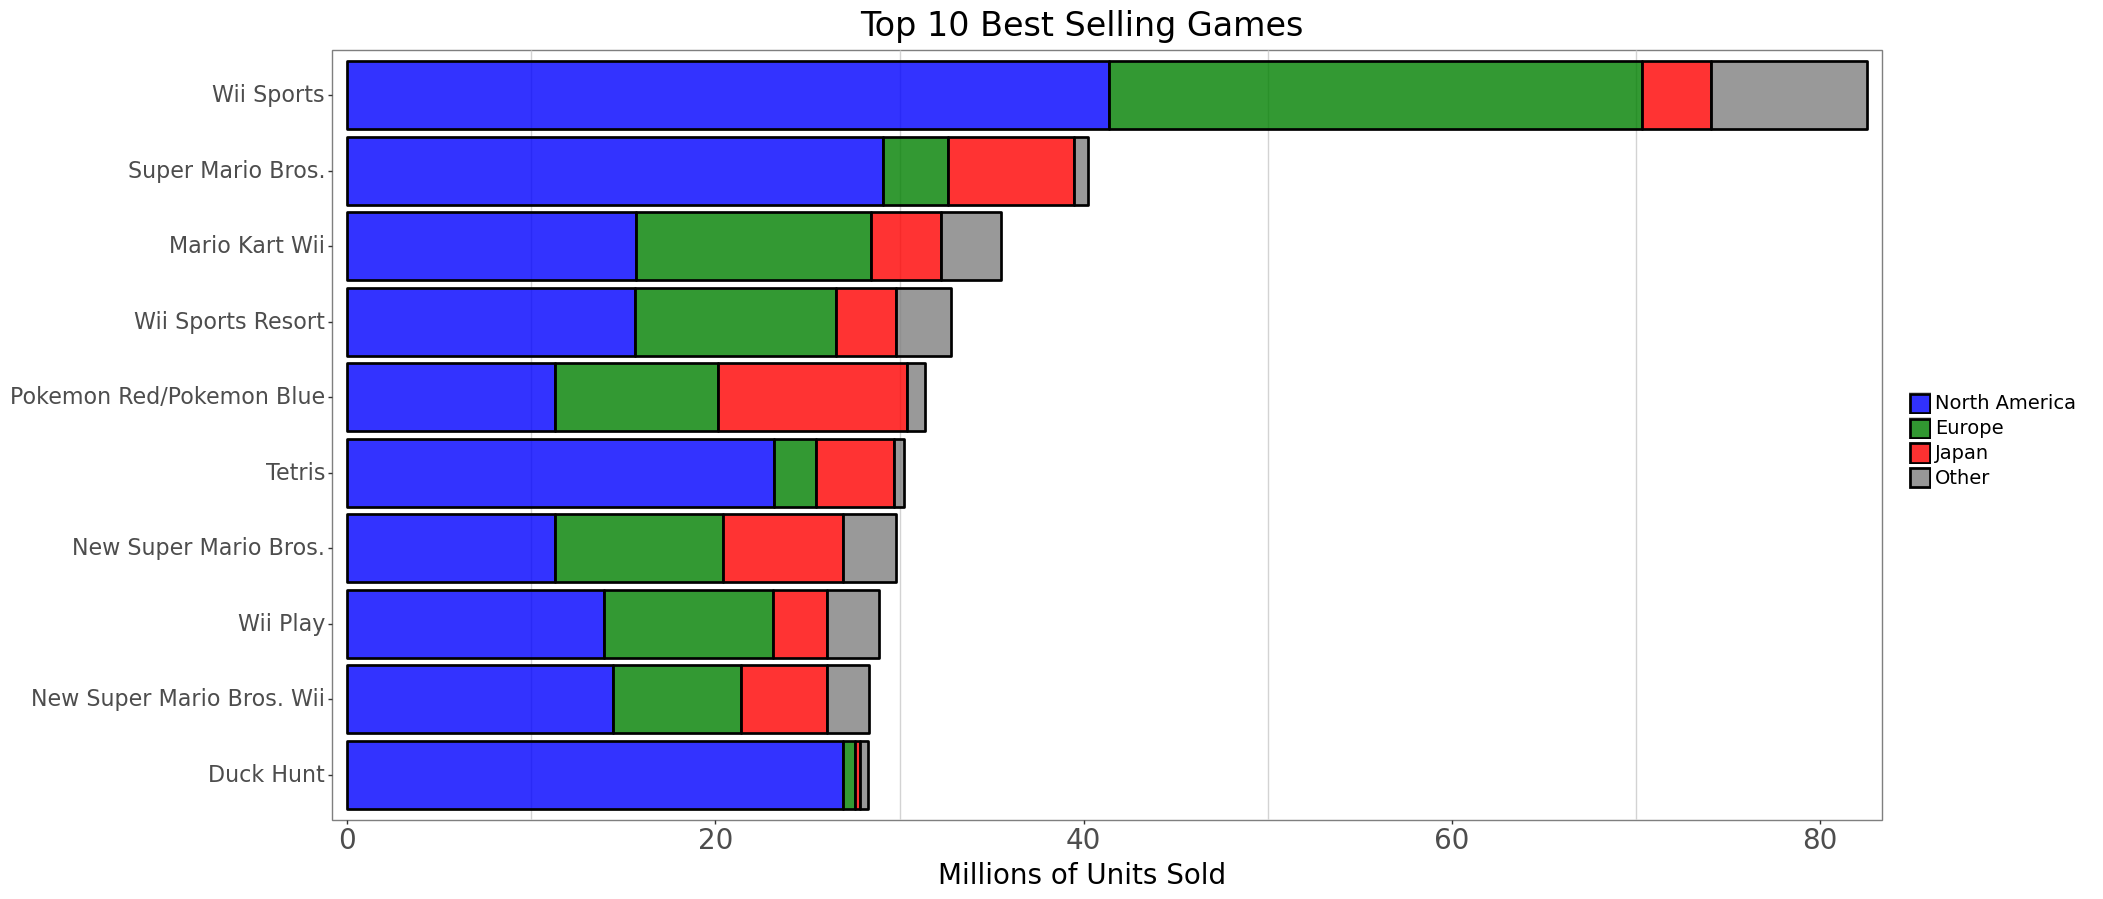

<ggplot: (124969972505)>

In [226]:
df2 = df.sort_values("global_sales", ascending = False).\
head(10).\
assign(name = lambda x: x.name.astype("category").cat.reorder_categories(x.set_index("name").sort_values("global_sales").index.tolist())).\
rename(columns = {"na_sales": "North America", 
                  "eu_sales": "Europe", 
                  "jp_sales": "Japan", 
                  "other_sales": "Other"}).\
loc[:, ["name", "North America", "Europe", "Japan", "Other"]].\
melt(id_vars = "name", value_vars = ["North America", "Europe", "Japan", "Other"], var_name = "region", value_name = "sales").\
assign(region = lambda x: x.region.astype("category").cat.reorder_categories(["Other", "Japan", "Europe", "North America"]))

(ggplot(df2, aes(x = "name", y = "sales", fill = "region")) + 
 geom_bar(stat = "identity", color = "black", alpha = .8, size = 1.1) + 
coord_flip() + 
scale_fill_manual({"North America": "blue",
                   "Europe": "green",
                   "Japan": "red",
                   "Other": "grey"}, guide = guide_legend(reverse = True))+ 
 scale_y_continuous(expand = [.01, 0]) + 
 labs(title = "Top 10 Best Selling Games", 
      x = "", 
      y = "Millions of Units Sold", 
      fill = "") + 
 theme_bw() + 
 theme(axis_text_x = element_text(size = 20), 
       axis_text_y = element_text(size = 16),
       axis_title_x = element_text(size = 20), 
       legend_position = "right", 
       legend_text = element_text(size = 14), 
       panel_grid_major = element_blank(),
       panel_grid_minor = element_line(color = "#d3d3d3"), 
       plot_title = element_text(size = 24)))

Points of interest
* **Bundled Games:** Wii Sports and Super Mario Bros. sales numbers are inflated because they were both bundled with the Nintendo Entertainment System and Nintendo Wii. Wii Play was also bundled with the Wiimote controller for no additional cost. Wii Sports Resort was bundled with the Wii Motion Plus (adapter to enhance the Wiimote for certain games).
* **Multiple Iterations:** Pokemon Red/Pokemon Blue are two versions of the same game. They are nearly identical aside from a few minor differences. Hardcore fans would buy both eidtions to get the complete game increasing its sales numbers. 
* **Nintendo**: All of these games are on Nintendo consoles. and all are rated E for Everyone. These games have a high sales ceiling with mass market appeal.

## Game Sales Over Time
I know anecdotedly that the video game industry has grown over time. Let's see if the sales data back that up.

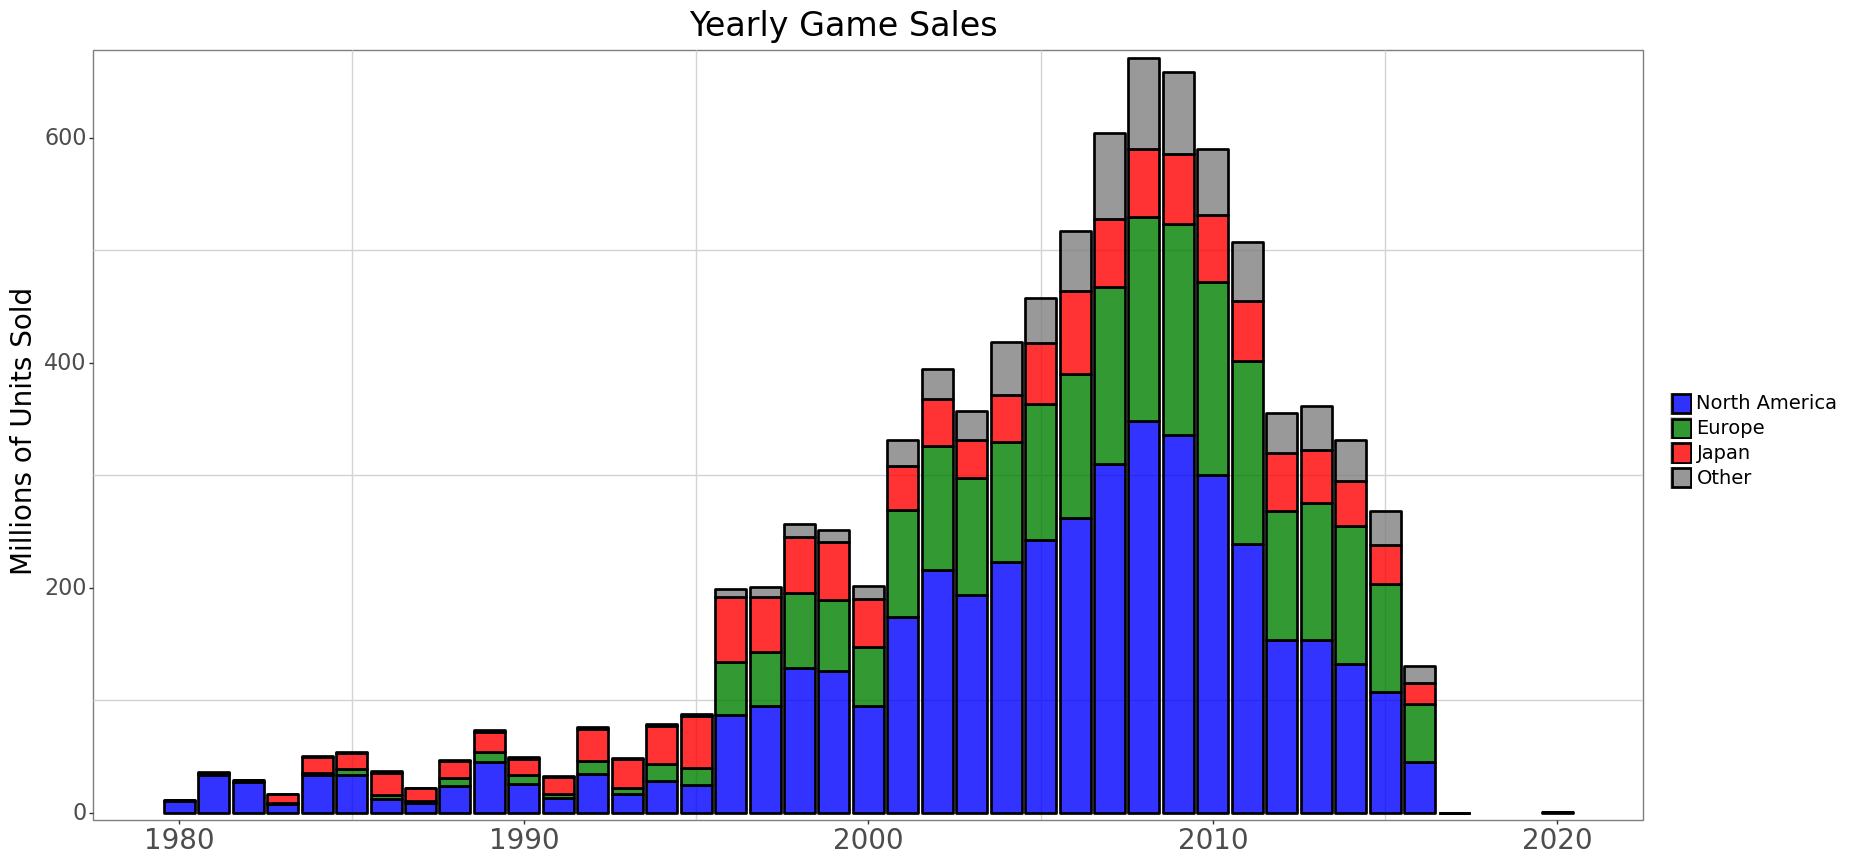

<ggplot: (124972906253)>

In [227]:
df2 = df[df['year_of_release'].notnull()].rename(columns = {"na_sales": "North America", 
                      "eu_sales": "Europe", 
                      "jp_sales": "Japan", 
                      "other_sales": "Other"}).\
loc[:, ["year_of_release", "North America", "Europe", "Japan", "Other"]].\
melt(id_vars = "year_of_release", value_vars = ["North America", "Europe", "Japan", "Other"], var_name = "region", value_name = "sales").\
assign(region = lambda x: x.region.astype("category").cat.reorder_categories(["Other", "Japan", "Europe", "North America"])).\
groupby(["year_of_release", "region"]).\
aggregate({"sales": "sum"}).\
reset_index().assign(year_of_release = lambda x: x.year_of_release.astype(int))


(ggplot(df2, aes(x = "year_of_release", y = "sales", fill = "region")) + 
 geom_bar(stat = "identity", color = "black", alpha = .8, size = 1.1) + 
scale_fill_manual({"North America": "blue",
                   "Europe": "green",
                   "Japan": "red",
                   "Other": "grey"}, guide = guide_legend(reverse = True))+ 
 scale_y_continuous(expand = [.01, 0]) + 
 labs(title = "Yearly Game Sales", 
      x = "", 
      y = "Millions of Units Sold", 
      fill = "") + 
 theme_bw() + 
 theme(axis_text_x = element_text(size = 20), 
       axis_text_y = element_text(size = 16),
       axis_title = element_text(size = 20), 
       legend_position = "right", 
       legend_text = element_text(size = 14), 
       panel_grid_major = element_blank(),
       panel_grid_minor = element_line(color = "#d3d3d3"), 
       plot_title = element_text(size = 24)))

We can see a steady growth until about 2008/2009 where sales begin to drop off. This is around the time when major games became available both physically and digitally. Digital sales are not tracked in VG Chartz so as digital sales become more of the norm, the data become less reliable. The dataset is also about 6 years old at this point so you won't see much after 2016.

## Top Selling Genres
Let's see how game sales differ across genres.

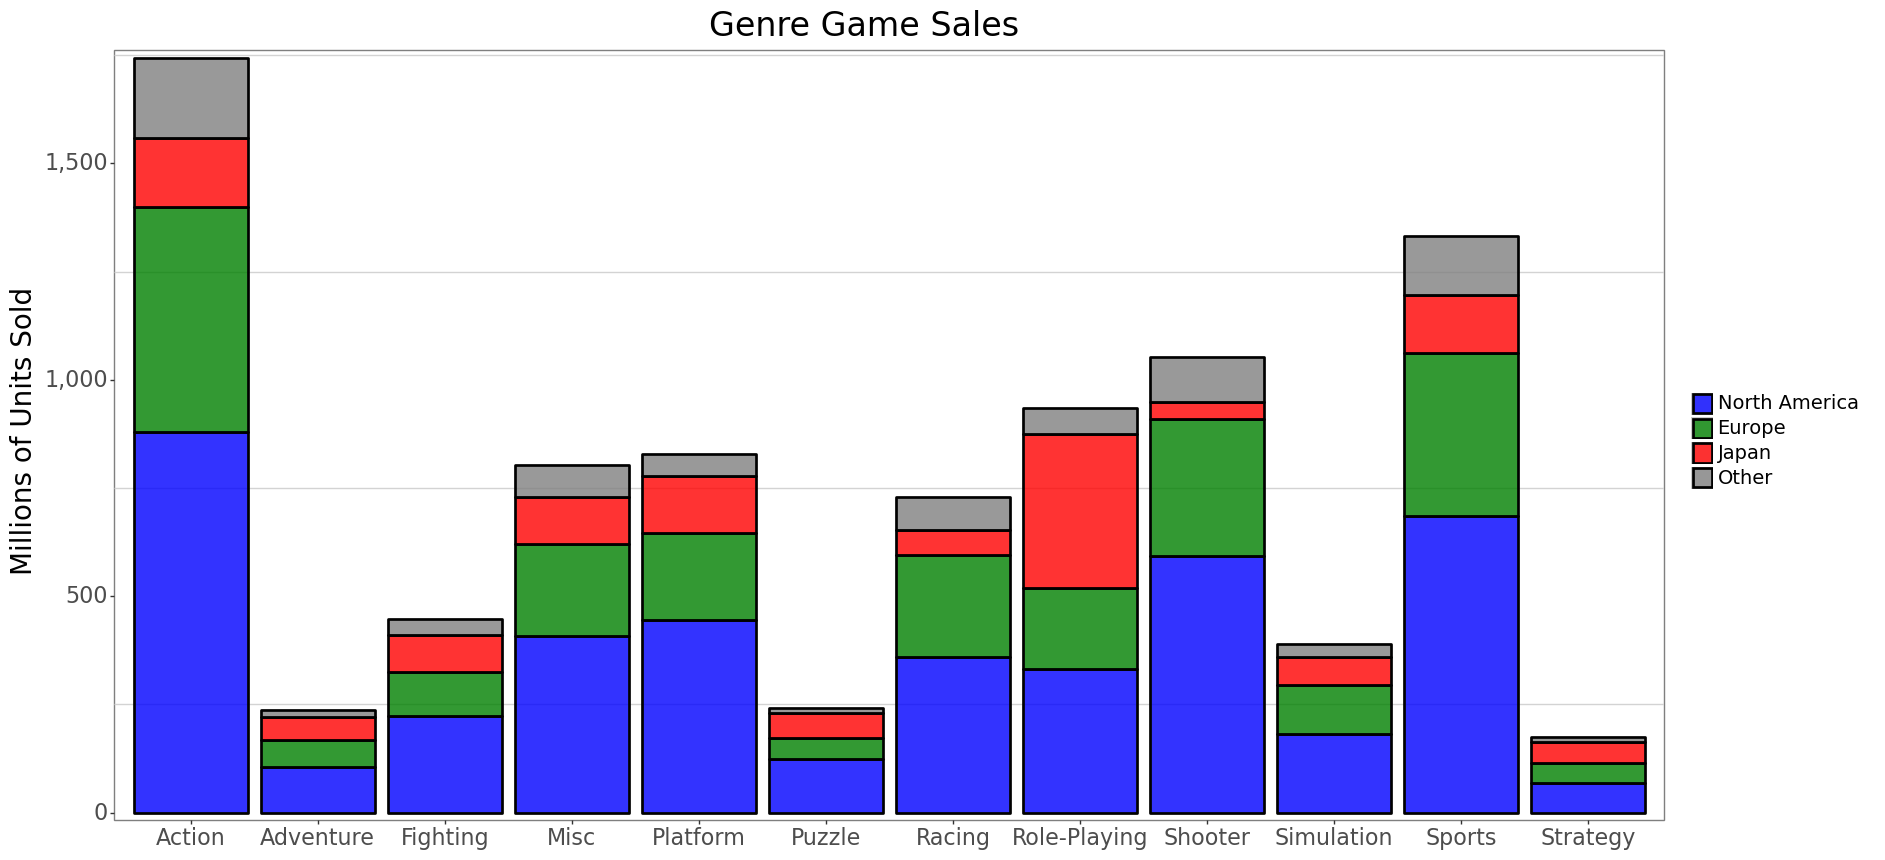

<ggplot: (124973050531)>

In [228]:
# do this twice. Once for sales and another for regional sales

df2 = df[df['genre'].notnull()].rename(columns = {"na_sales": "North America", 
                      "eu_sales": "Europe", 
                      "jp_sales": "Japan", 
                      "other_sales": "Other"}).\
loc[:, ["genre", "North America", "Europe", "Japan", "Other"]].\
melt(id_vars = "genre", value_vars = ["North America", "Europe", "Japan", "Other"], var_name = "region", value_name = "sales").\
assign(region = lambda x: x.region.astype("category").cat.reorder_categories(["Other", "Japan", "Europe", "North America"]), 
      skus = 1).\
groupby(["genre", "region"]).\
aggregate({"sales": "sum", 
          "skus": "sum"}).\
reset_index().\
assign(regional_sales = lambda x: x.sales/x.skus)


(ggplot(df2, aes(x = "genre", y = "sales", fill = "region")) + 
 geom_bar(stat = "identity", color = "black", alpha = .8, size = 1.1) + 
scale_fill_manual({"North America": "blue",
                   "Europe": "green",
                   "Japan": "red",
                   "Other": "grey"}, guide = guide_legend(reverse = True))+ 
 scale_y_continuous(labels = comma_format(), expand = [.01, 0]) + 
 labs(title = "Genre Game Sales", 
      x = "", 
      y = "Millions of Units Sold", 
      fill = "") + 
 theme_bw() + 
 theme(axis_text_x = element_text(size = 16), 
       axis_text_y = element_text(size = 16),
       axis_title = element_text(size = 20), 
       legend_position = "right", 
       legend_text = element_text(size = 14), 
       panel_grid_major = element_blank(),
       panel_grid_minor = element_line(color = "#d3d3d3"), 
       plot_title = element_text(size = 24)))

As games have become more varied and complicated, their genre distinctions have become more vague. There are Shooters with Role-Playing elements, Adventure games with lots of puzzle elements, etc. Many games get grouped in Action despite having elements of other genres. 

Another thing is the number of releases. Most sports game series release annually whereas an action game series may release a new entry every 2-3 years. Because of this, we should check the number of games game releases of each genre.

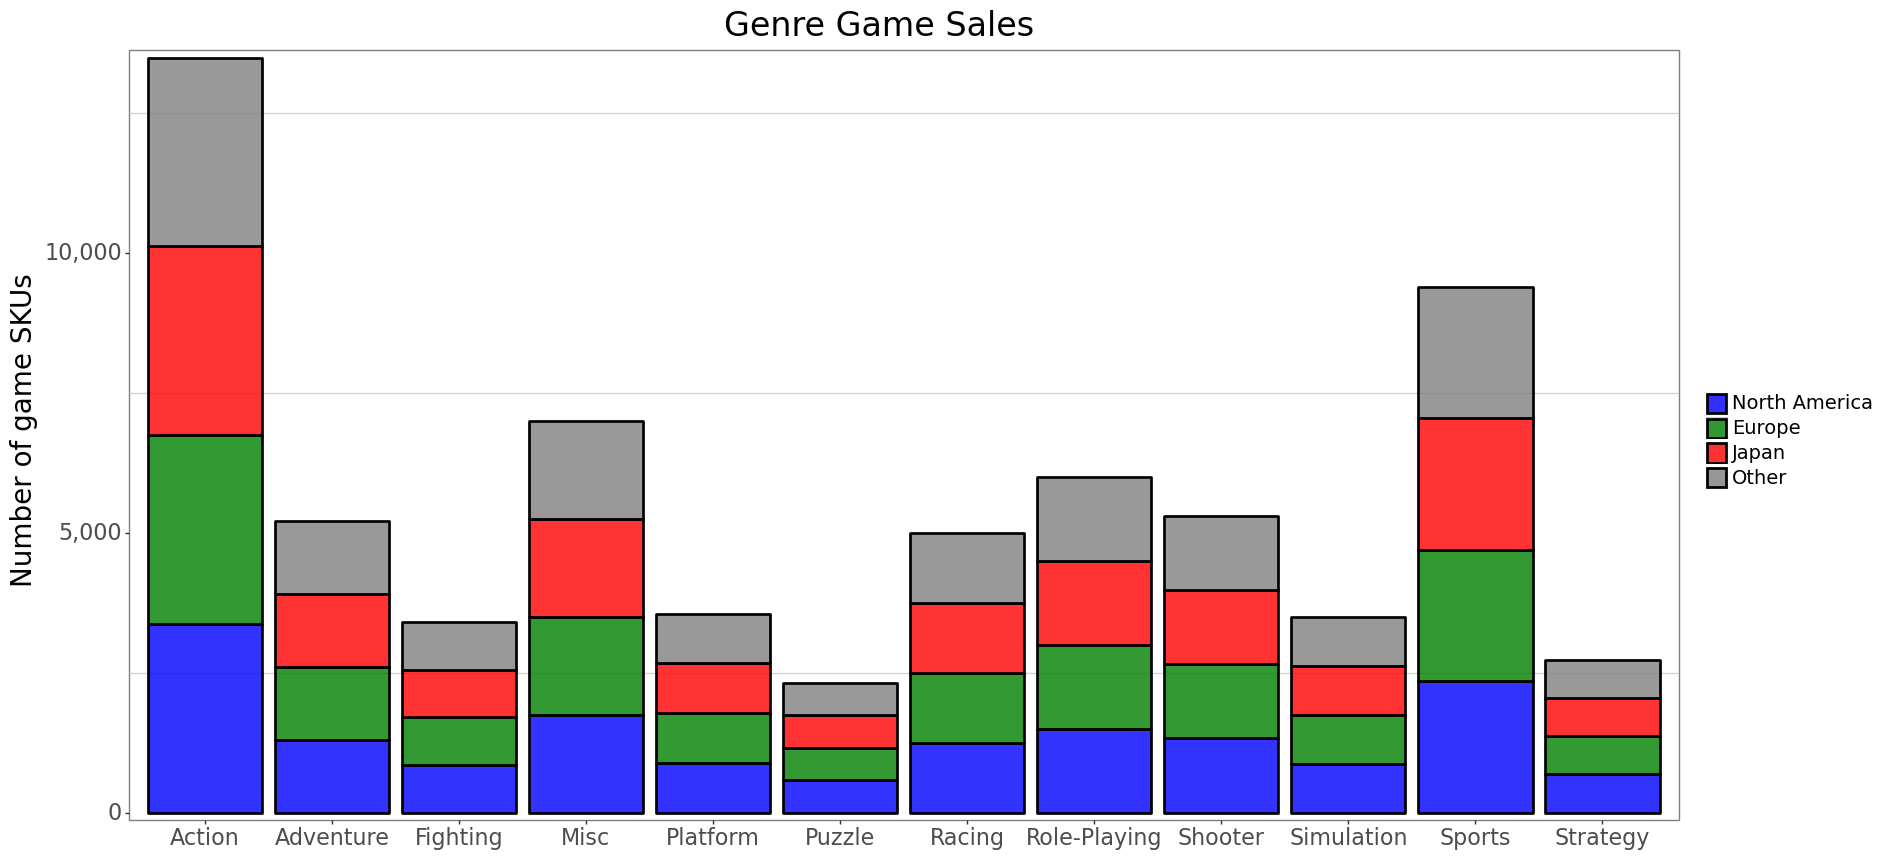

<ggplot: (124966983961)>

In [229]:
(ggplot(df2, aes(x = "genre", y = "skus", fill = "region")) + 
 geom_bar(stat = "identity", color = "black", alpha = .8, size = 1.1) + 
scale_fill_manual({"North America": "blue",
                   "Europe": "green",
                   "Japan": "red",
                   "Other": "grey"}, guide = guide_legend(reverse = True))+ 
 scale_y_continuous(labels = comma_format(), expand = [.01, 0]) + 
 labs(title = "Genre Game Sales", 
      x = "", 
      y = "Number of game SKUs", 
      fill = "") + 
 theme_bw() + 
 theme(axis_text_x = element_text(size = 16), 
       axis_text_y = element_text(size = 16),
       axis_title = element_text(size = 20), 
       legend_position = "right", 
       legend_text = element_text(size = 14), 
       panel_grid_major = element_blank(),
       panel_grid_minor = element_line(color = "#d3d3d3"), 
       plot_title = element_text(size = 24)))

You can see the top 2 genres in terms of number of releases are Action and Sports so their high sales are due to the fact that so many games fall under those genres. Shooters are surprisingly in the upper-middle of the pack despite their high sales so they are selling more on average than other genres.

## Sales by ESRB Rating
The ESRB rates every game similarly to how movies and TV shows are rated. The scale goes 
* **EC:** Early Childhood (deprecated)
* **E:** Everyone
* **K-A:** Kids to Adult (6 and up | deprecated)
* **E10+:** Everyone 10+ (10 and up)
* **T:** Teen (13 and up)
* **M:** Mature (17 and up)
* **AO:** Adults Only (18 and up | Rarely used)
* **RP:** Rating Pending (essentially NA)

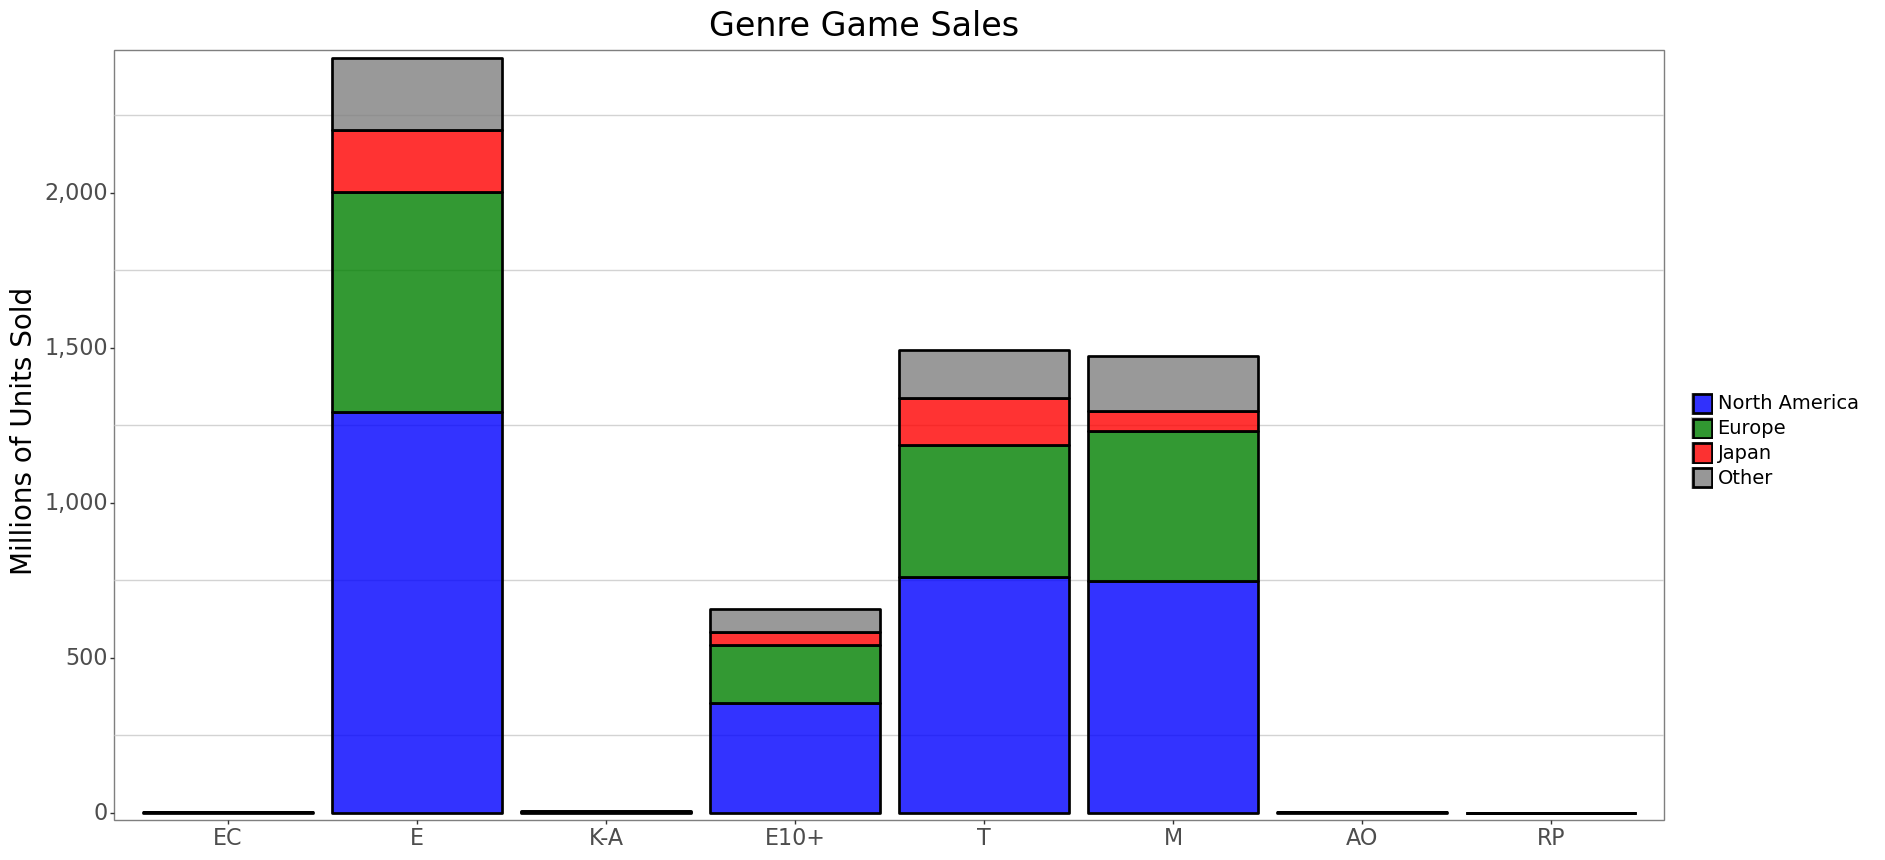

<ggplot: (124967382998)>

In [230]:
df2 = df[df['rating'].notnull()].rename(columns = {"na_sales": "North America", 
                      "eu_sales": "Europe", 
                      "jp_sales": "Japan", 
                      "other_sales": "Other"}).\
loc[:, ["rating", "North America", "Europe", "Japan", "Other"]].\
melt(id_vars = "rating", value_vars = ["North America", "Europe", "Japan", "Other"], var_name = "region", value_name = "sales").\
assign(region = lambda x: x.region.astype("category").cat.reorder_categories(["Other", "Japan", "Europe", "North America"]), 
       rating = lambda x: x.rating.astype("category").cat.reorder_categories(["EC", "E", "K-A", "E10+", "T", "M", "AO", "RP"]),
      skus = 1).\
groupby(["rating", "region"]).\
aggregate({"sales": "sum", 
          "skus": "sum"}).\
reset_index().\
assign(regional_sales = lambda x: x.sales/x.skus)


(ggplot(df2, aes(x = "rating", y = "sales", fill = "region")) + 
 geom_bar(stat = "identity", color = "black", alpha = .8, size = 1.1) + 
scale_fill_manual({"North America": "blue",
                   "Europe": "green",
                   "Japan": "red",
                   "Other": "grey"}, guide = guide_legend(reverse = True))+ 
 scale_y_continuous(labels = comma_format(), expand = [.01, 0]) + 
 labs(title = "Genre Game Sales", 
      x = "", 
      y = "Millions of Units Sold", 
      fill = "") + 
 theme_bw() + 
 theme(axis_text_x = element_text(size = 16), 
       axis_text_y = element_text(size = 16),
       axis_title = element_text(size = 20), 
       legend_position = "right", 
       legend_text = element_text(size = 14), 
       panel_grid_major = element_blank(),
       panel_grid_minor = element_line(color = "#d3d3d3"), 
       plot_title = element_text(size = 24)))

Most games (especially older games) are rated E so that will naturally have the highest sales. E10 is a newer rating that was introduced so it makes sense that its total sales are lower than the rest. What's interesting is that T and M games have the same sales. I and everyone I know played plenty of M rated games before reaching the age of 17 (don't tell my mom) but it's surprising that enough did to the point where its total sales matched T rated games. There are also fewer M rated games as publishers will occasionally design games to be T rated to increase sales potential.

## Sales by Critic Scores
Some conspriacy theorists on the internet believe video game ciritics are paid to give games positive reviews, but are critic scores correlated with sales?

Correlation Coefficient: 0.25


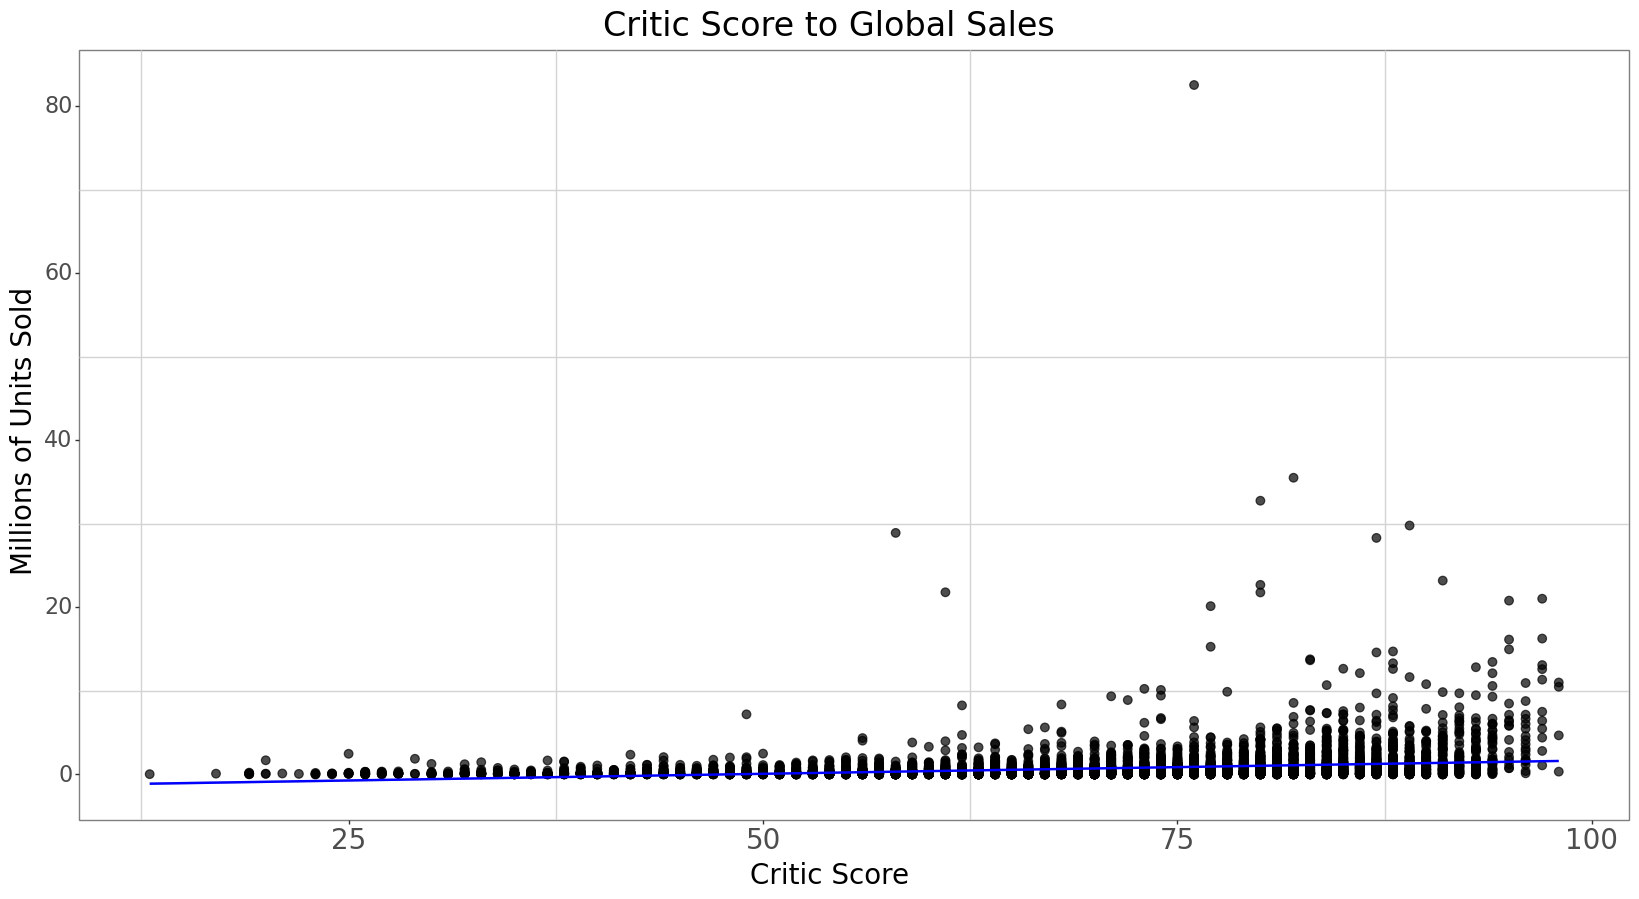

<ggplot: (124967418263)>

In [231]:
corr_coef = round(df.corr().loc["critic_score", "global_sales"], 2).astype(str)

(ggplot(df, aes(x = "critic_score", y = "global_sales")) + 
      geom_point(size = 3, alpha = 0.7) + 
 geom_smooth(method = "lm", stat = "smooth", color = "blue") + 
 labs(title = "Critic Score to Global Sales", 
      caption = print("Correlation Coefficient: " + corr_coef),
      x = "Critic Score", 
      y = "Millions of Units Sold", 
      fill = "") + 
 theme_bw() + 
 theme(axis_text_x = element_text(size = 20), 
       axis_text_y = element_text(size = 16),
       axis_title = element_text(size = 20), 
       legend_position = "right", 
       legend_text = element_text(size = 14), 
       panel_grid_major = element_blank(),
       panel_grid_minor = element_line(color = "#d3d3d3"), 
       plot_title = element_text(size = 24)))

Critic scores have no relation with game sales. Even the most critically acclaimed games will have the potential to sell very poorly. There are so many other factors like the platforms the game is released on, the competition, release date, etc that determine how many copies a game will sell. Critic scores have never made much of an impact.

# Summary of Findings
* Game sales can be boosted by having multiple slightly different editions or bundled with hardware. Nintendo is notorious for doing this
* As we transition to the digital age, tracking game sales will become impossible unless every online marketplace makes their data public which will likely never happen
* Shooters have very high sales per game released
* Despite the age gate, Mature games sell about on par Teen games. This is counter-intuitive to the practice of developing what should creatively a Mature rated game as a Teen rated game
* Critic Scores have little to no relation with game sales. People buy games for other reasons